# Classification with Naive Bayes

# Automated spam filtering

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve

## Step 1: Load data, look around

In the data directory of the repository, you should see a file called `SMSSpamCollection`, about 0.5MB in size:

This file contains **a collection of more than 5 thousand SMS phone messages**. This line of code puts each line of SMS message into a list as a list element.

In [2]:
messages = [line.rstrip() for line in open('../data/SMSSpamCollection.txt')]
print(len(messages))

5574


A collection of texts is also sometimes called "corpus". Let's print the first ten messages in this SMS corpus:

In [3]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

We see that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message ("ham") or "spam". The second column is the message itself.

This corpus will be our labeled training set. Using these ham/spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

[![](http://radimrehurek.com/data_science_python/plot_ML_flow_chart_11.png)](http://www.astroml.org/sklearn_tutorial/general_concepts.html#supervised-learning-model-fit-x-y)

Instead of parsing TSV (or CSV, or Excel...) files by hand, we can use Python's `pandas` library to do the work for us:

In [4]:
messages = pandas.read_csv('../data/SMSSpamCollection.txt', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print(messages)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...
10     ham  I'm gonna be home soon and i don't want to tal...
11    spam  SIX chances to win CASH! From 100 to 20,000 po...
12    spam  URGENT! You have won a 1 week FREE membership ...
13     ham  I've been searching for the right words to tha...
14     ham                I HAVE A DATE ON SUNDAY WITH WILL!!
15    sp

With `pandas`, we can also view aggregate statistics easily:

In [5]:

# examine the shape
messages.shape

(5574, 2)

In [6]:
messages.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [7]:
messages['label'].value_counts()

ham     4827
spam     747
Name: label, dtype: int64

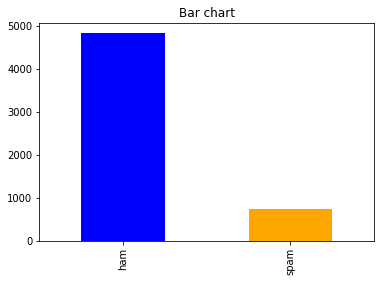

In [8]:
import pandas as pd

count_Class=pd.value_counts(messages["label"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

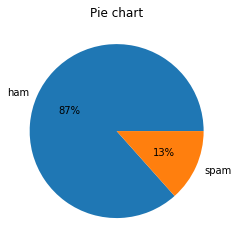

In [9]:
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

A neat pacakge in Python is the collections package and the Counter function within it.  It tallies up data very quickly, see [documentation](https://docs.python.org/2/library/collections.html).

Note:  The code below is for exemplifying how we go from text messages to the features, the individual words of the messages.  The code is complicated, but here so you can see how this may be done. 

In [13]:
from collections import Counter

data = messages
#This code splits the 

count1 = Counter(" ".join(data[data['label']=='ham']["message"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['label']=='spam']["message"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})
df1

,words in non-spam,count
0,to,1538
1,you,1462
2,I,1439
3,the,1029
4,a,977
5,i,742
6,and,739
7,in,736
8,u,651
9,is,645


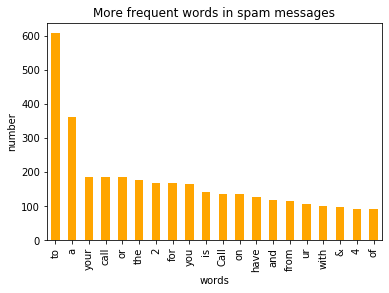

In [14]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

## How do we represent text as data that can be modeled?  

Let's take a close look at a very simple example of how we would represent a training and test dataset of SMS messages for machine learning.  Rather than the code above, we can use tools, like CountVectorizer, to convert text into its "word" features.

We need to get a count of each word in the message as a feature.  There is a nice easy way to do this [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [24]:
# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

In [27]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [29]:
# learn the 'vocabulary' of the training data and transform 
# it into a 'document-term matrix'. Unlike models, for any 
# feature extraction or data-preprocessing toolkit, we use transform 
# instead of fit, since it's taking some data and "transforming" it,
# fit_transform is just a shortcut for calling .fit and .transform separately
simple_train_dtm = vect.fit_transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [30]:
# convert sparse matrix to a dense matrix 
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [31]:
# examine the fitted vocabulary
vect.get_feature_names()

['cab', 'call', 'me', 'please', 'tonight', 'you']

In [32]:
# examine the vocabulary and document-term matrix together.
# 3 * 6 matrix, because there're three documents and six tokens that were learned
# each number represents the counts for each token in each document
# we call this a document term matrix
pd.DataFrame(simple_train_dtm.toarray(), columns = vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [33]:
# check the type of the document-term matrix
print(type(simple_train_dtm))

# examine the sparse matrix contents
# represented coordinates, and the values at that coordinates
print(simple_train_dtm)

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 1)	1
  (0, 5)	1
  (0, 4)	1
  (1, 1)	1
  (1, 2)	1
  (1, 0)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


In [34]:
# example text for model testing
simple_test = ["please don't call me"]

In [35]:
# transform testing data into a document-term matrix,
# using the existing vocabulary from the training data
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [36]:
# examine the vocabulary and document-term matrix together
pd.DataFrame( simple_test_dtm.toarray(), columns = vect.get_feature_names() )

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


Summary:

* vect.fit(train) learns the vocabulary of the training data.
* vect.transform(train) uses the fitted vocabulary to build a document-term matrix from the training data. Or just vect.fit_transform(train) to combine the two steps into one.
* vect.transform(test) uses the fitted vocabulary to build a document-term matrix from the testing data. Note that it ignores tokens it hasn't seen before, this is reasonable due to the fact that the word does not exist in the training data, thus the model doesn't know anything about the relationship between the word and the output.

## Now back to the SMS larger dataset - building a model and testing a prediction

You'll remember from our last lecture introducing machine learning that you need some requirements for machine learning:  First, we need to determine your X and y datasets.  We need to first define what we want to predict, and that is whether a message is ham or spam.  to this, we will transform the variable spam/non-spam into binary variables.  Next, we'll split our data into a training set and test set.

In [40]:

# Ham and Spam to binary
messages["label_no"]=messages["label"].map({'spam':1,'ham':0})
y = messages['label_no']
messages.head()



,label,message,label_no
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [41]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
# COUNTVECTORIZER will be used to split the SMS into tallies of each word 
# It accepts one-dimension data
X = messages['message']
y = messages['label_no']
print(X.shape)
print(y.shape)

(5574,)
(5574,)


In [42]:
# This function splits into training and testing easily
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
print(X_train.shape)
print(X_test.shape)

(4180,)
(1394,)


In [43]:
# instantiate the vectorizer
vect = CountVectorizer()

# learn training data vocabulary, then use it to create a document-term matrix
# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)

In [44]:

# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [45]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

The first metric we are going to discuss is, perhaps, the simplest one, the accuracy. It answers the question:
“How often is the classifier correct?”
It can be obtained simply using the following formulae:

sklearn provides the function accuracy_score to obtain the accuracy:

In [46]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)


0.9885222381635581

Thus, our spam filtering algorithm has an accuracy of 99%, that is, for each 100 emails it classified, 99 were correctly classified as spam or not spam.

Does this mean that our algorithm has an excellent performance? Suppose that our dataset had 99% real emails and 1% spam and that we built a classifier that predicted that all emails were real. Then, this algorithm would be 99% accurate, but horrible at classifying spam! It is important to have other ways to measure the performance of the algorithm.


The confusion matrix is another metric that is often used to measure the performance of a classification algorithm. 

For are example, the confusion matrix will be of the following form:

|                    | Predicted: HAM SMS | Predicted: SPAM SMS |
|--------------------|-----------------------|-----------------------|
| Actual: HAM SMS | True Positives (TP)   | False Negative (FN)  |
| Actual: SPAM SMS | False Positive (FP)  | True Negatives (TN)   |

The predicted classes are represented in the columns of the matrix, whereas the actual classes are in the rows of the matrix. We then have four cases:

* True positives (TP): the cases for which the classifier predicted ‘ham’ and the texts were actually ham.
* True negatives (TN): the cases for which the classifier predicted ‘not ham’ and the texts were actually 'not ham' or real.
* False positives (FP): the cases for which the classifier predicted ‘ham’ but the texts were actually 'spam'.
* False negatives (FN): the cases for which the classifier predicted ‘spam’ but the texts were actually real.

In [2]:
# print the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_class)
cmdf = pd.DataFrame(cm,index=['0', '1'], columns=['0','1'])
print("The confusion matrix looks like following...\n")
cmdf

NameError: name 'metrics' is not defined


From the confusion matrix, we see that the Naive Bayes classifier got the following results:

Out of the 1206 + 6 = 1212 actual instances of 'ham' (not spam), it predicted correctly 1206 of them;
Out of the 182 actual instances of spam, it predicted correctly 172 of them.


Note that the accuracy may be obtained from the confusion matrix, as the sum of the diagonal divided by the sum of all matrix entries.

Accuracy = (TP + TN) / (TP+TN+FP+FN)

In [48]:
float(cm[0,0]+cm[1,1])/float(cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])


0.9885222381635581

Besides the accuracy, there are several other performance measures which can be computed from the confusion matrix. Some of the main ones are obtained using the function classification_report:

In [49]:

print("The classification report is as follows...\n")
print(classification_report(y_pred_class,y_test))

The classification report is as follows...

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1216
           1       0.95      0.97      0.96       178

    accuracy                           0.99      1394
   macro avg       0.97      0.98      0.97      1394
weighted avg       0.99      0.99      0.99      1394



#### Precision

“When it predicts the positive result, how often is it correct?”
This is obtained by using the following formulae:

Precision = TP / (TP + FP)

Precision is usually used when the goal is to limit the number of false positives (FP). For example, this would be the metric to focus on if our goal with the spam filtering algorithm is to minimize the number of reals emails that are classified as spam.

#### Recall

“When it is actually the positive result, how often does it predict correctly?”
This is obtained by using the following formulae:

Recall = TP / (TP + FN)

Recall is usually used when the goal is to limit the number of false negatives (FN). In our example, that would correspond to minimizing the number of spam emails that are classified as real emails. Recall is also known as “sensitivity” and “true positive rate” (TPR).

#### f1-score

This is the harmonic mean of precision and recall:

f1-score = 2 * precision*recall / (precision + recall)

It is useful when you need to take both precision and recall into account. If you try to only optimize recall, your algorithm will predict most examples to belong to the positive class, but that will result in many false positives and, hence, low precision. On the other hand, if you try to optimize precision, your model will predict very few examples as positive results (the ones which highest probability), but recall will be very low.


#### ROC curve

A more visual way to measure the performance of a binary classifier is the receiver operating characteristic (ROC) curve. It is created by plotting the true positive rate (TPR) (or recall) against the false positive rate (FPR), which we haven’t defined explicitly yet:

FP rate = FP / (FP + TN)

The question it is trying to answer is:  “When it is actually the negative result, how often does it predict incorrectly?”

Let’s see how we can obtain this curve. First, note that our Naive Bayes algorithm isn’t only able to predict if each email is spam or not, but it can also give us the predicted probability for such event. The predicted probability for the test set can be obtained in sklearn with:

In [37]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]

Now that we have the predicted probabilities for each email, how do we decide if it is spam based on the values of those probabilities? That is, what is threshold for the probability above which we classify the email as spam?
It seems reasonable, at least at first, to take the threshold to be 0.5. The nice thing about the ROC curve is that we can visualize how the performance of the classifier changes as we vary the threshold.
First, let’s plot the ROC curve for the case at hand by importing roc_curve from sklearn.metrics, which gives us the TP and FP rates:

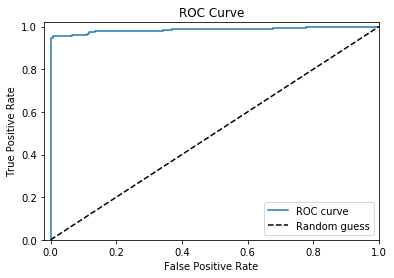

In [38]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="lower right")

To understand this plot, let’s analyse it in steps.

Suppose we take the threshold to be 0, that is, all emails are classified as spam. 
On the one hand, this implies that no spam emails are predicted as real emails and so there are no false negatives — the true positive rate (or recall) is 1. On the other hand, this also means that no real email is classified as real, and thus there are no true negatives — the false positive rate is also 1. This corresponds to the top-right part of the curve.

Now suppose that the threshold is 1, that is, no email is classified as spam. Then, there are no true positives (and thus the true positive rate is 0) and no false positives (and thus the false positive rate is 0). This corresponds to the bottom-left of the curve.

The rest of the curve corresponds to values of the threshold between 0 and 1, from the top-right to the bottom-left. As you can see, the curve approaches (but does not reach) the corner of the plot where the TP rate is 1 and the FP rate is 0 — that is, no spam emails are classified as real and no real emails are classified as spam. This is the point of perfect classification.

The TP rate is the proportion of emails predicted as spam which are actually spam. The FP rate is the proportion of actual real emails which are predicted as spam.

If we are in the diagonal line, that means that the proportion of emails predicted as spam which turn out to be actual spam is roughly the same as the proportion of real emails which are predicted as spam. This is as good as random guessing, and a classifier with this performance would be pretty terrible.

The above points suggest that the area under the ROC curve (usually denoted by AUC) is a good measure of the performance of the classification algorithm. If it is near 0.5, the classifier is not much better than random guessing, whereas it gets better as the area gets close to 1.

We can obtain the AUC by importing roc_auc_score from sklearn.metrics:

In [39]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9856698581946108

The AUC is indeed quite close to 1, and so our classifier is very good at minimizing false negatives (spam which is classified as real) and true negatives (real email which is classified as real).

Note that, since we are taking the area under the whole ROC curve, the result is not related to any particular threshold. Therefore, a high AUC does not tell us which is the best threshold to obtain useful classification predictions.

#### Precision-recall curve

As discussed above, changing the threshold for the predicted probability (above which we classify the email as spam) has an effect on the performance of the algorithm. For example, the true positive rate, or recall, is 0 if we set the threshold as 1, as no email is classified as spam, so it might be a good idea to have a smaller threshold. But having a recall of 1 is not necessarily good, as a model which classifies everything as spam has recall equal to 1, but also very low precision, as there will be a lot of false positives.

A good way to illustrate this trade-off between precision and recall is with the precision-recall curve. It can be obtained by importing precision_recall_curve from sklearn.metrics:

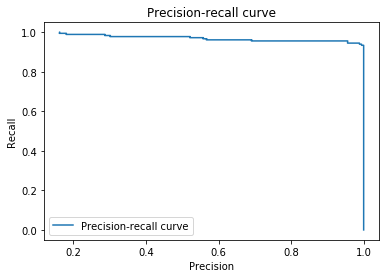

In [40]:
from sklearn.metrics import precision_recall_curve 

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-recall curve')
plt.legend(loc="lower left")


As with the ROC curve, each point in the plot corresponds to a different threshold. Threshold equal to 0 implies that the recall is 1, whereas threshold equal to 1 implies that the recall is 0, so the threshold varies from 0 to 1 from the top-left to the bottom-right of the plot. Note that the precision starts from roughly 0.7, as there aren’t many false positives (real emails classified as spam).

With the precision-recall curve, the closer it is to the top-right corner, the better the algorithm. And hence a larger area under the curve (AUC) indicates that the algorithm has higher recall and higher precision. 

In this context, the area is known as average precision and can be obtained by importing roc_auc_score from sklearn.metrics,


In [41]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

# train the model using X_train_dtm
# it accepts both sparse and dense arrays
logreg.fit(X_train_dtm, y_train)

# calculate predicted probabilities for X_test_dtm (well calibrated)
# it's a good model if you care about predicting the classified probability
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

/Users/adina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.00216574, 0.00906657, 0.00519045, ..., 0.00317454, 0.9995216 ,
       0.02041351])

In [42]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, y_pred_prob)

0.9824775009662473

Once again, this number is not connected with any particular threshold (we are averaging over all possible thresholds), and so it doesn’t tell us which is the best threshold to consider for useful classification predictions.

In [43]:
# print message text for the false positives (ham incorrectly classified as spam)
print('false positives')
print(X_test[(y_pred_class == 1) & (y_test == 0)])
# equivalent way to performing the operation
# print(X_test[y_pred_class > y_test])


# print message text for the false negatives (spam incorrectly classified as ham)
print('\nfalse negatives')
print(X_test[y_pred_class < y_test])

# example false negative
X_test[1875]

false positives
3415                    No pic. Please re-send.
4600    Have you laid your airtel line to rest?
574                      Waiting for your call.
45             No calls..messages..missed calls
4702                     I liked the new mobile
4622         Received, understood n acted upon!
Name: message, dtype: object

false negatives
1875    Would you like to see my XXX pics they are so ...
4514    Money i have won wining number 946 wot do i do...
684     Hi I'm sue. I am 20 years old and work as a la...
5       FreeMsg Hey there darling it's been 3 week's n...
5037    You won't believe it but it's true. It's Incre...
3419    LIFE has never been this much fun and great un...
4069    TBS/PERSOLVO. been chasing us since Sept for£3...
2823    ROMCAPspam Everyone around should be respondin...
4256    Block Breaker now comes in deluxe format with ...
1893    CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
Name: message, dtype: object


'Would you like to see my XXX pics they are so hot they were nearly banned in the uk!'

After looking at these incorrectly classified messages, you might think does the message's length have something to do with it being a spam/ham.

Next, we will examine the our trained Naive Bayes model to calculate the approximate "spamminess" of each token to see which word appears more often in spam messages.

In [44]:
# Naive Bayes counts the number of times each token appears in each class, where
# rows represent classes, columns represent tokens
# and the trailing _ is just the convention that's used to denote attributes that
# are learned during the model fitting process
print(nb.feature_count_)

# extract the number of times each token appears across all HAM and SPAM messages
ham_token_count = nb.feature_count_[0, :]
spam_token_count = nb.feature_count_[1, :]

[[ 0.  0.  0. ...  1.  0.  1.]
 [ 6. 18.  1. ...  0.  1.  0.]]


In [45]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
print(len(X_train_tokens))

# examine the first or last 50 tokens if you wish
# print(X_train_tokens[0:50])
# print(X_train_tokens[-50:])

# create a DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame({
    'token': X_train_tokens, 
    'ham': ham_token_count, 
    'spam': spam_token_count
}).set_index('token')
tokens.head()

7446


,ham,spam
token,,
00,0.0,6.0
000,0.0,18.0
008704050406,0.0,1.0
0089,0.0,1.0
0121,0.0,1.0


In [46]:
# examine 5 random DataFrame rows
tokens.sample(5, random_state = 6)

,ham,spam
token,,
kothi,2.0,0.0
chinnu,1.0,0.0
hg,0.0,8.0
ibhltd,0.0,3.0
lover,6.0,1.0


In [47]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([3615.,  565.])

Before we can calculate the relative "spamminess" of each token, we need to avoid dividing by zero and account for the class imbalance.

In [48]:
# add 1 to ham and spam counts to avoid dividing by 0
# convert the ham and spam counts into ratio frequencies
tokens['ham'] = (tokens['ham'] + 1) / nb.class_count_[0]
tokens['spam'] = (tokens['spam'] + 1) / nb.class_count_[1]

# calculate the conceptual ratio of spam-to-ham for each token
tokens['spam_ratio'] = tokens['spam'] / tokens['ham']
tokens.sample(5, random_state = 6)

,ham,spam,spam_ratio
token,,,
kothi,0.000830,0.001770,2.132743
chinnu,0.000553,0.001770,3.199115
hg,0.000277,0.015929,57.584071
ibhltd,0.000277,0.007080,25.592920
lover,0.001936,0.003540,1.828066


In [49]:
# examine the DataFrame sorted by spam_ratio
# only interpret them as relative ratio instead of actual ratio 
# since we added the one to prevent zero division
tokens.sort_values('spam_ratio', ascending = False).head()

,ham,spam,spam_ratio
token,,,
claim,0.000277,0.164602,595.035398
prize,0.000277,0.132743,479.867257
150p,0.000277,0.095575,345.504425
tone,0.000277,0.092035,332.707965
guaranteed,0.000277,0.074336,268.725664


In [50]:
# look up the spam_ratio for a given token
tokens.loc['dating', 'spam_ratio']

83.17699115044248

In [51]:
def vis_coef(estimator, feature_names, topn = 10):
    """
    Visualize the top-n most influential coefficients
    for linear models.

    Parameters
    ----------
    estimator : sklearn-like linear model
        An estimator that contains the attribute
        ``coef_``.

    feature_names : str 1d array or list[str]
        Feature names that corresponds to the coefficients.

    topn : int, default 10
        Here topn refers to the largest positive and negative coefficients,
        i.e. a topn of 10, would show the top and bottom 10, so a total of
        20 coefficient weights.
    """
    fig = plt.figure()
    n_classes = estimator.coef_.shape[0]
    feature_names = np.asarray(feature_names)
    for idx, coefs in enumerate(estimator.coef_, 1):
        sorted_coefs = np.argsort(coefs)
        positive_coefs = sorted_coefs[-topn:]
        negative_coefs = sorted_coefs[:topn]
        top_coefs = np.hstack([negative_coefs, positive_coefs])

        colors = ['#A60628' if c < 0 else '#348ABD' for c in coefs[top_coefs]]
        y_pos = np.arange(2 * topn)
        fig.add_subplot(n_classes, 1, idx)
        plt.barh(y_pos, coefs[top_coefs], color = colors, align = 'center')
        plt.yticks(y_pos, feature_names[top_coefs])
        plt.title('top {} positive/negative coefficient'.format(topn))

    plt.tight_layout()

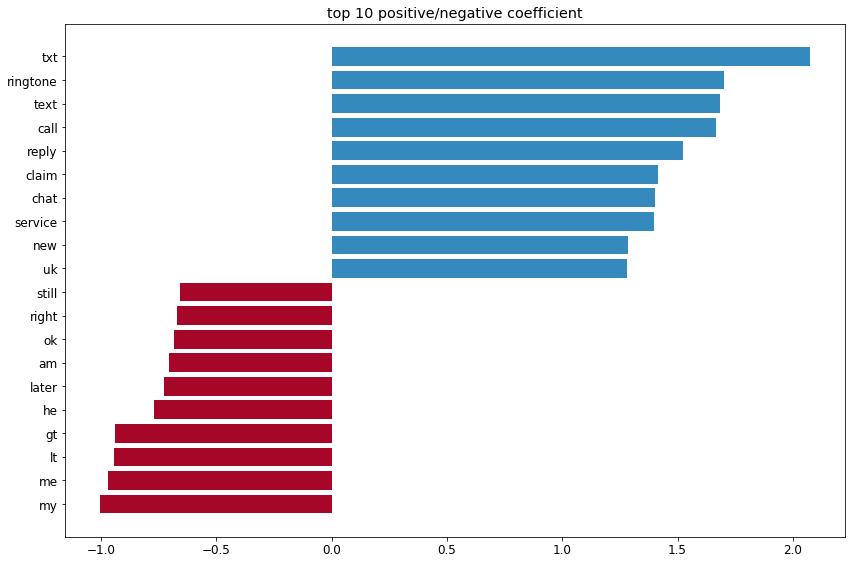

In [52]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 12

feature_names = vect.get_feature_names()
coef_plot = vis_coef(logreg, feature_names, topn = 10)
plt.show()

From the following:  http://ethen8181.github.io/machine-learning/text_classification/basics/basics.html.  You can watch him doing this tutorial at:  https://www.youtube.com/watch?v=znfy3T9OiAQ
